# Figure 3: OHC upper 700m, timeseries + Hovmoeller  

1) Evalutate first cell to import necessary libraries und functions  
2) Scroll down to Plotting to load data for Figure 3 and plotting code

In [ ]:
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.patches as mpatches
import cmocean as cmo
import numpy as np
import cartopy.crs as ccrs
import cartopy
import pandas as pd
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
from scipy.interpolate import griddata
from scipy.io import loadmat
import datetime
# from datetime import datetime
import string

import sys
sys.path.append("./")  # adds upper level to working directory\n
from utils_iohc_ummenhofer2020 import deseason,ohc_anomaly,cut_indo,plot_map,finished_plot,add_ipo_bar,mask_2D_percentile


# where to save plots
plotsave = 'plots'
datapath = '/vortexfs1/share/clidex/data/'

In [ ]:
# baseline period for anomalies
base = ['1960-01-01','2012-12-31']


# values for heat content calculation
cp = 3994 # heat capacity
rho = 1029 # reference density
# cp and rho from https://xgcm.readthedocs.io/en/latest/example_eccov4.html

# masks
masktype = 'orca' # 'levitus'

if masktype=='orca': mask = xr.open_dataset(datapath+'ORCA/mesh_files/new_maskglo.nc')
elif masktype=='levitus': mask = xr.open_dataset('./data/mask_ind_levitus_orca.nc')

# Load data

In [ ]:
################### load data ######################
zrange = slice(0,22)  #3m-734m for temp data
datapath2 = datapath+'publications/IOHC_Ummenhofer/'
k003 = xr.open_dataset(datapath2 + 'K003.hindcast_temp_IndoPacific_30E_150W_70S_30N.nc',
                      chunks={'x': 200, 'y': 200, 'time_counter': 200}).isel(deptht=zrange)
k004 = xr.open_dataset(datapath2 + 'K004.thermhal90_temp_IndoPacific_30E_150W_70S_30N.nc',
                     chunks={'x': 200, 'y': 200, 'time_counter': 200}).isel(deptht=zrange)
k005 = xr.open_dataset(datapath2 + 'K005.wind90_temp_IndoPacific_30E_150W_70S_30N.nc',
                      chunks={'x': 200, 'y': 200, 'time_counter': 200}).isel(deptht=zrange)


###############################################################################
############################# load mask ########################################
###############################################################################
# load mask
%timeit
# rename dimesion to match
mask_orca = mask.rename({'X':'x', 'Y':'y'}).drop(['x','y'])
# cut out indo region
mask_orca = cut_indo(mask_orca['tmaskind']).to_dataset()

###############################################################################
############################ load mesh variables ###############################
###############################################################################

# horizontal 
meshpath = datapath+'ORCA/mesh_files/'
mesh = xr.open_dataset(meshpath + 'mesh_hgr.nc').sel(z=zrange)
# spatical weights (e1t=zonal, e2t=meridional)
e2t = mesh['e2t']
e2t = e2t.rename({'t':'time_counter'}).squeeze()
e1t = mesh['e1t']
e1t = e1t.rename({'t':'time_counter'}).squeeze()

# vertical
mesh = xr.open_dataset(meshpath + 'mesh_zgr.nc').sel(z=zrange)
# vertical weight
e3t = mesh['e3t_0']
e3t = e3t.rename({'t':'time_counter', 'z':'deptht'})
e3t = e3t.squeeze()

# also need to cut weights for multiplication
w3 = cut_indo(e3t).to_dataset()
w3["deptht"] = k003['deptht']
w2 = cut_indo(e2t)
w1 = cut_indo(e1t)
# temperature mask (not sure what this does exactly)
tmask = xr.open_dataset(meshpath + 'mask.nc')['tmask'].isel(z=zrange)
tmask = cut_indo(tmask)
tmask = np.squeeze(tmask.rename({'z':'deptht'}))

## Derive heat content 

In [ ]:
# create masks for eastern and western basins

mask_east = mask_orca.copy(deep=True)
mask_east = mask_east.where(k003['nav_lon'].values>90)

mask_west = mask_orca.copy(deep=True)
mask_west = mask_west.where((k003['nav_lon'].values<=90) & (k003['nav_lon'].values>0) )

# plot masks
fig,ax = plot_map(figsize=(7,3))
ax.pcolormesh(k003['nav_lon'],k003['nav_lat'],mask_east['tmaskind']
              .where(mask_east['tmaskind']!=0),cmap=plt.get_cmap('RdYlBu'))
ax.pcolormesh(k003['nav_lon'],k003['nav_lat'],mask_west['tmaskind']
              .where(mask_west['tmaskind']!=0))
ax.set_extent([20,140,-35,32], crs=ccrs.PlateCarree())

In [ ]:
# depth integrated OHC 
weights = w2.values * w1.values * w3['e3t_0'].values * tmask 
ohc_k003_700_east = ohc_anomaly(k003['votemper'],mask_east,weights=weights,dims=['deptht','y','x'],
                           base=base).load()
ohc_k003_700_west = ohc_anomaly(k003['votemper'],mask_west,weights=weights,dims=['deptht','y','x'],
                           base=base).load()

ohc_k004_700_east = ohc_anomaly(k004['votemper'],mask_east,weights=weights,dims=['deptht','y','x'],
                           base=base).load()
ohc_k004_700_west = ohc_anomaly(k004['votemper'],mask_west,weights=weights,dims=['deptht','y','x'],
                           base=base).load()

ohc_k005_700_east = ohc_anomaly(k005['votemper'],mask_east,weights=weights,dims=['deptht','y','x'],
                           base=base).load()
ohc_k005_700_west = ohc_anomaly(k005['votemper'],mask_west,weights=weights,dims=['deptht','y','x'],
                           base=base).load()

In [ ]:
# save to netcdf
ohc_k003_700_east.drop('month').to_dataset(name='OHC').to_netcdf('../data/Fig3_k003_ohc_700_east.nc')
ohc_k003_700_west.drop('month').to_dataset(name='OHC').to_netcdf('../data/Fig3_k003_ohc_700_west.nc')

ohc_k004_700_east.drop('month').to_dataset(name='OHC').to_netcdf('../data/Fig3_k004_ohc_700_east.nc')
ohc_k004_700_west.drop('month').to_dataset(name='OHC').to_netcdf('../data/Fig3_k004_ohc_700_west.nc')

ohc_k005_700_east.drop('month').to_dataset(name='OHC').to_netcdf('../data/Fig3_k005_ohc_700_east.nc')
ohc_k005_700_west.drop('month').to_dataset(name='OHC').to_netcdf('../data/Fig3_k005_ohc_700_west.nc')

In [ ]:
# basin integrated OHC for Hovmoeller plot

weights = w2.values * w3['e3t_0'].values * tmask 
k003_ohc_hovm_east = ohc_anomaly(k003['votemper'],mask_east,weights=weights,dims=['y','x'],
                           base=base).load()
k003_ohc_hovm_west = ohc_anomaly(k003['votemper'],mask_west,weights=weights,dims=['y','x'],
                           base=base).load()

k004_ohc_hovm_east = ohc_anomaly(k004['votemper'],mask_east,weights=weights,dims=['y','x'],
                           base=base).load()
k004_ohc_hovm_west = ohc_anomaly(k004['votemper'],mask_west,weights=weights,dims=['y','x'],
                           base=base).load()

k005_ohc_hovm_east = ohc_anomaly(k005['votemper'],mask_east,weights=weights,dims=['y','x'],
                           base=base).load()
k005_ohc_hovm_west = ohc_anomaly(k005['votemper'],mask_west,weights=weights,dims=['y','x'],
                           base=base).load()

# save to netcdf
k003_ohc_hovm_east.to_dataset(name='OHC').to_netcdf('../data/Fig3_k003_ohc_hovm_east.nc')
k003_ohc_hovm_west.to_dataset(name='OHC').to_netcdf('../data/Fig3_k003_ohc_hovm_west.nc')

k004_ohc_hovm_east.to_dataset(name='OHC').to_netcdf('../data/Fig3_k004_ohc_hovm_east.nc')
k004_ohc_hovm_west.to_dataset(name='OHC').to_netcdf('../data/Fig3_k004_ohc_hovm_west.nc')

k005_ohc_hovm_east.to_dataset(name='OHC').to_netcdf('../data/Fig3_k005_ohc_hovm_east.nc')
k005_ohc_hovm_west.to_dataset(name='OHC').to_netcdf('../data/Fig3_k005_ohc_hovm_west.nc')

# Plotting

## Load data for figure

In [ ]:
# depth integrated OHC
ohc_k003_700_east = xr.open_dataset('../data/Fig3_k003_ohc_700_east.nc')['OHC']
ohc_k003_700_west = xr.open_dataset('../data/Fig3_k003_ohc_700_west.nc')['OHC']

ohc_k004_700_east = xr.open_dataset('../data/Fig3_k004_ohc_700_east.nc')['OHC']
ohc_k004_700_west = xr.open_dataset('../data/Fig3_k004_ohc_700_west.nc')['OHC']

ohc_k005_700_east = xr.open_dataset('../data/Fig3_k005_ohc_700_east.nc')['OHC']
ohc_k005_700_west = xr.open_dataset('../data/Fig3_k005_ohc_700_west.nc')['OHC']

# basin integrated OHC for Hovmoeller plot
k003_ohc_hovm_east = xr.open_dataset('../data/Fig3_k003_ohc_hovm_east.nc')['OHC']
k003_ohc_hovm_west = xr.open_dataset('../data/Fig3_k003_ohc_hovm_west.nc')['OHC']

k004_ohc_hovm_east = xr.open_dataset('../data/Fig3_k004_ohc_hovm_east.nc')['OHC']
k004_ohc_hovm_west = xr.open_dataset('../data/Fig3_k004_ohc_hovm_west.nc')['OHC']

k005_ohc_hovm_east = xr.open_dataset('../data/Fig3_k005_ohc_hovm_east.nc')['OHC']
k005_ohc_hovm_west = xr.open_dataset('../data/Fig3_k005_ohc_hovm_west.nc')['OHC']



### East-West

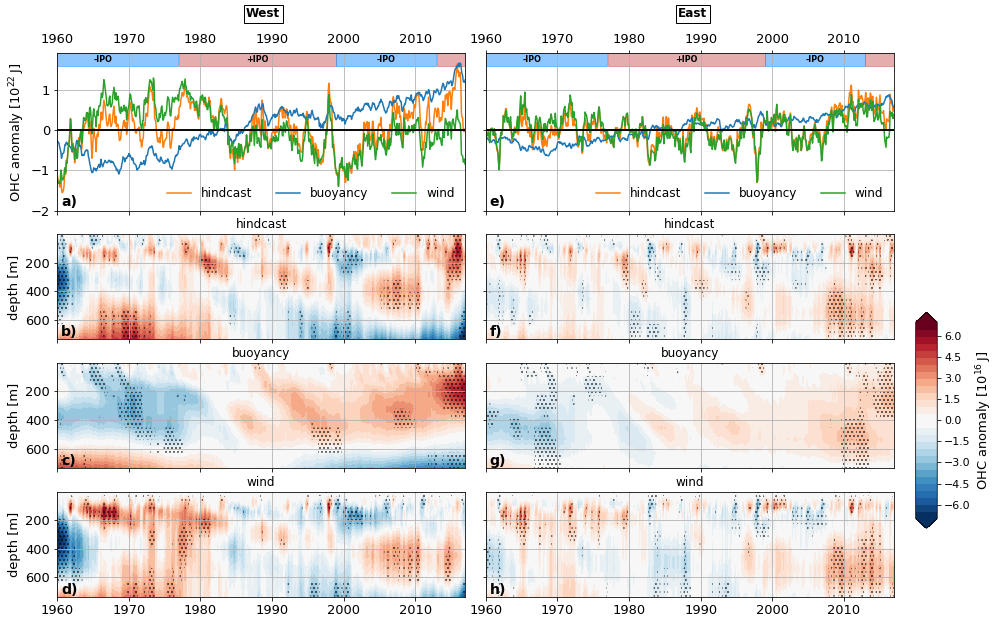

In [3]:
# Figure properties
cols = plt.get_cmap("tab10")
plt.rcParams.update({'font.size': 13})
fig2 = plt.figure(figsize=(15,10))
widths = [1,1]
heights = [1.5,1,1,1]
grid = fig2.add_gridspec(ncols=2, nrows=4, width_ratios=widths,
                          height_ratios=heights,hspace=0.2,wspace=0.05)


n=0
#
for loc,i in zip(['west','east'],range(2)):
    if loc=='west':
        ohc_k003 = ohc_k003_700_west; ohc_k004 = ohc_k004_700_west;ohc_k005 = ohc_k005_700_west;
    elif loc=='east':
        ohc_k003 = ohc_k003_700_east; ohc_k004 = ohc_k004_700_east;ohc_k005 = ohc_k005_700_east;
    
    ax1 = fig2.add_subplot(grid[0, i])
    (ohc_k003/1e22).plot(ax=ax1,label='hindcast',color=cols(1),linewidth=1.5)
    (ohc_k004/1e22).plot(ax=ax1,label='buoyancy',color=cols(0),linewidth=1.5)
    (ohc_k005/1e22).plot(ax=ax1,label='wind',color=cols(2),linewidth=1.5)
    ax1.axhline(0,color='black')
    ax1.set_ylabel('OHC anomaly [$10^{22}\,$J]')
    ax1.set_xlabel('')
    ax1.set_xlim(['1955-01-01','2019-01-01'])
    ax1.xaxis.tick_top()
    ax1.axhline(0,color='k')
    cmap = plt.get_cmap('RdBu_r',len(np.arange(-0.7,0.7,0.05))-1)
    ax1.legend(ncol=3,fontsize=12,loc='lower right',frameon=False)
    ax1.set_ylim(-2,1.9)
    add_ipo_bar(ax1)
    #
    #
    if loc=='west':
        ohc_k003 = k003_ohc_hovm_west; ohc_k004 = k004_ohc_hovm_west; ohc_k005 = k005_ohc_hovm_west;
    elif loc=='east':
        ohc_k003 = k003_ohc_hovm_east; ohc_k004 = k004_ohc_hovm_east; ohc_k005 = k005_ohc_hovm_east;
        
    # K003
    ax2 = fig2.add_subplot(grid[1, i])
    hh = (ohc_k003/1e16).sel(deptht=slice(0,750)).T \
            .plot.contourf(levels=np.arange(-7,7.5,0.5),ax=ax2,add_colorbar=False,
                          cmap=cmap,extend='both',vmin=-7,vmax=7)
    ax2.pcolor(ohc_k003['time_counter'],ohc_k003['deptht'],
               mask_2D_percentile(ohc_k003,95,'above').T,
               hatch='...',alpha=0.)
    ax2.pcolor(ohc_k003['time_counter'],ohc_k003['deptht'],
                   mask_2D_percentile(ohc_k003,5,'below').T,
                   hatch='...',alpha=0.)
#     plot_perc(ohc_k003,ax2,95)
#     plot_perc(ohc_k003,ax2,5)

    ax2.invert_yaxis()
    ax2.set_xlim(['1955-01-01','2019-01-01'])
    ax2.set_xlabel('')
    ax2.set_ylabel('depth [m]')
    ax2.set_xticklabels('')
    ax2.set_title('hindcast',fontsize=12)

    #
    # K004
    ax3 = fig2.add_subplot(grid[2, i])
    hh = (ohc_k004/1e16).sel(deptht=slice(0,750)).T \
            .plot.contourf(levels=np.arange(-7,7.5,0.5),ax=ax3,add_colorbar=False,
                          cmap=cmap,extend='both',vmin=-7,vmax=7)
    ax3.pcolor(ohc_k004['time_counter'],ohc_k004['deptht'],
           mask_2D_percentile(ohc_k004,95,'above').T,
           hatch='...',alpha=0.)
    ax3.pcolor(ohc_k004['time_counter'],ohc_k004['deptht'],
               mask_2D_percentile(ohc_k004,5,'below').T,
               hatch='...',alpha=0.)
#     plot_perc(ohc_k004,ax3,95)
#     plot_perc(ohc_k004,ax3,5)
    
    ax3.invert_yaxis()
    ax3.set_xlim(['1955-01-01','2019-01-01'])
    ax3.set_xlabel('')
    ax3.set_ylabel('depth [m]')
    ax3.set_xticklabels('')
    ax3.set_title('buoyancy',fontsize=12)

    #
    # K005
    ax4 = fig2.add_subplot(grid[3, i], sharex=ax1)
    hh = (ohc_k005/1e16).sel(deptht=slice(0,750)).T \
            .plot.contourf(levels=np.arange(-7,7.5,0.5),ax=ax4,add_colorbar=False,
                          cmap=cmap,extend='both',vmin=-7,vmax=7)
    ax4.pcolor(ohc_k005['time_counter'],ohc_k005['deptht'],
           mask_2D_percentile(ohc_k005,95,'above').T,
           hatch='...',alpha=0.)
    ax4.pcolor(ohc_k005['time_counter'],ohc_k005['deptht'],
               mask_2D_percentile(ohc_k005,5,'below').T,
               hatch='...',alpha=0.) 
#     plot_perc(ohc_k005,ax4,95)
#     plot_perc(ohc_k005,ax4,5)
    
    ax4.invert_yaxis()
    ax4.set_xlim(['1955-01-01','2019-01-01'])
    ax4.set_xlabel('')
    ax4.set_ylabel('depth [m]')
    ax4.set_title('wind',fontsize=12)
    
    for label in ax4.get_xticklabels():
        label.set_ha("center")
        label.set_rotation(0)
    
    
    for ax in [ax1,ax2,ax3,ax4]:
#         if i == 0: xloc = -0.07
#         else: xloc=1.03
        ax.text(0.01, 0.03, string.ascii_lowercase[n]+')', transform=ax.transAxes, 
                    size=14, weight='bold')
        n=n+1
        ax.tick_params(bottom=True, top=False)
        ax.grid()
        ax.set_xlim('1960-01-01','2017-01-01')
#

cbaxes = fig2.add_axes([0.92, 0.22, 0.02, 0.3]) 
cb = plt.colorbar(hh, cax = cbaxes,label='OHC anomaly [$10^{16}\,$J]',extend='both') 
cb.ax.tick_params(labelsize=11) 

for ax in [ax1,ax2,ax3,ax4]:
    ax.set_ylabel('')
    ax.set_yticklabels('')

ax1.tick_params(bottom=True, top=True)
# ax1.legend(ncol=3,fontsize=12,loc='lower middle',frameon=False)

# column labels
t = plt.text(0.3, 0.93, 'West', transform=plt.gcf().transFigure,
                size=12, weight='bold',zorder=10)
t.set_bbox(dict(facecolor='w',boxstyle='square,pad=0.2'))
t = plt.text(0.7, 0.93, 'East', transform=plt.gcf().transFigure,
                size=12, weight='bold',zorder=10)
t.set_bbox(dict(facecolor='w',boxstyle='square,pad=0.2'))

# finished_plot(fig2,plotsave + 'Fig2_IO_ohc_anomaly_700m_east_west_test_stippling.png')
